学习R语言合成控制法。

In [3]:
library(tidysynth)
library(tidyverse)
data(smoking)
glimpse(smoking)

Rows: 1,209
Columns: 7
$ state     <chr> "Rhode Island", "Tennessee", "Indiana", "Nevada", "Louisiana~
$ year      <dbl> 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, ~
$ cigsale   <dbl> 123.9, 99.8, 134.6, 189.5, 115.9, 108.4, 265.7, 93.8, 100.3,~
$ lnincome  <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, ~
$ beer      <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, ~
$ age15to24 <dbl> 0.1831579, 0.1780438, 0.1765159, 0.1615542, 0.1851852, 0.175~
$ retprice  <dbl> 39.3, 39.9, 30.6, 38.9, 34.3, 38.4, 31.4, 37.3, 36.7, 28.8, ~


In [4]:
# 构建SCM模型
smoking_out <- smoking %>%
  # 初始化SCM
  synthetic_control(
    outcome = cigsale, # 结果变量Y
    unit = state, # 面板数据中的单元
    time = year, # 时间
    i_unit = "California", # 处理组
    i_time = 1988, # 干预实施时间
    generate_placebos = T  # 后续是否做安慰剂检验
  ) %>% 
  # 设置协变量为：1980-1988年人均收入的对数变换、卷烟平均销售价格、年龄为15-24岁人口比例、
  # 1984-1988年人均啤酒消费量、1975年卷烟销量、1980年卷烟销量、1988年卷烟销量
  generate_predictor(
    time_window = 1980:1988,
    ln_income = mean(lnincome, na.rm = T),
    ret_price = mean(retprice, na.rm = T),
    youth = mean(age15to24, na.rm = T)
  ) %>%
  generate_predictor(
    time_window = 1984:1988,
    beer_sales = mean(beer, na.rm = T)
  ) %>%
  generate_predictor(
    time_window = 1975,
    cigsale_1975 = cigsale
  ) %>%
  generate_predictor(
    time_window = 1980,
    cigsale_1980 = cigsale
  ) %>%
  generate_predictor(
    time_window = 1988,
    cigsale_1988 = cigsale
  ) %>%
  # 生成权重
  generate_weights(
    optimization_window = 1970:1988, # 干预前时间段
    margin_ipop = .02,
    sigf_ipop = 7,
    bound_ipop = 6 # optimizer options
  ) %>%
  # 生成对照
  generate_control()

In [7]:
# 输出干预前真实加州、合成加州、控制组的协变量表格
smoking_out %>% grab_balance_table()

variable,California,synthetic_California,donor_sample
<chr>,<dbl>,<dbl>,<dbl>
ln_income,10.0765586,9.8534864,9.8291968
ret_price,89.4222234,89.3908482,87.2660819
youth,0.1735324,0.1736054,0.1725101
beer_sales,24.2800003,24.2224860,23.6552632
cigsale_1975,127.0999985,126.9914177,136.9315790
cigsale_1980,120.1999969,120.2204841,138.0894737
cigsale_1988,90.0999985,91.3888620,113.8236837


In [8]:
# 输出协变量的相对重要性
smoking_out %>% grab_predictor_weights()

variable,weight
<chr>,<dbl>
ln_income,0.0002905674
ret_price,0.0546030525
youth,0.0073277957
beer_sales,0.0203974042
cigsale_1975,0.4683657835
cigsale_1980,0.4124182134
cigsale_1988,0.0365971832


In [ ]:
# 输出每个控制单元的权重
smoking_out %>% grab_unit_weights()

unit,weight
<chr>,<dbl>
Alabama,2.676583e-07
Arkansas,2.186981e-07
Colorado,1.487818e-01
Connecticut,6.166179e-02
Delaware,2.976259e-07
Georgia,2.789505e-07
Idaho,3.409784e-06
Illinois,7.113468e-07
Indiana,2.836491e-07


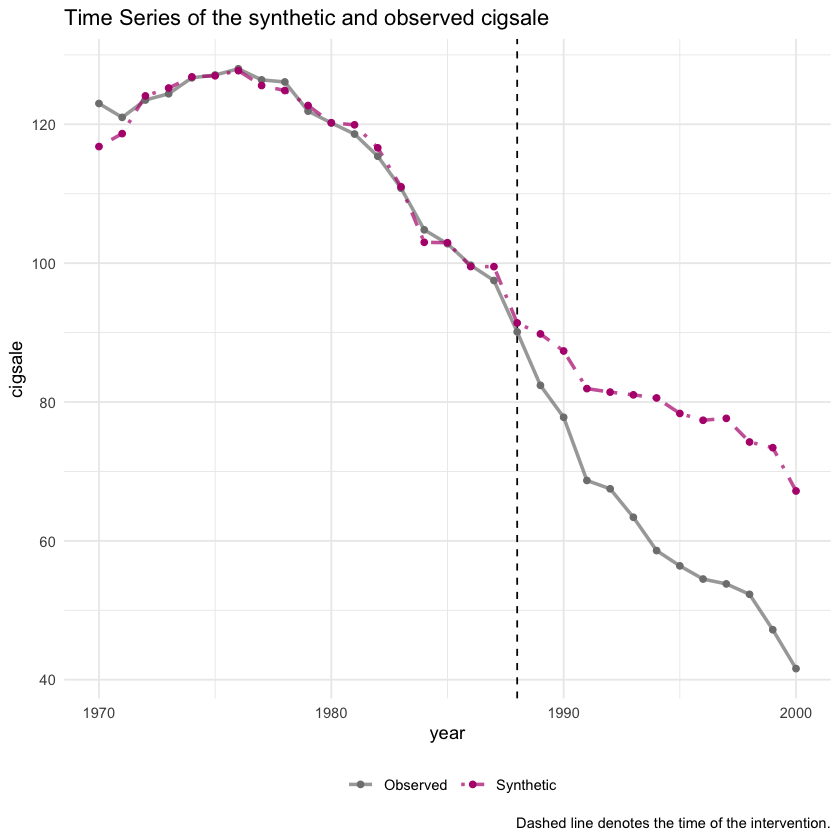

In [10]:
# 绘制真实加州和合成加州的人均卷烟销量趋势图
smoking_out %>% plot_trends()

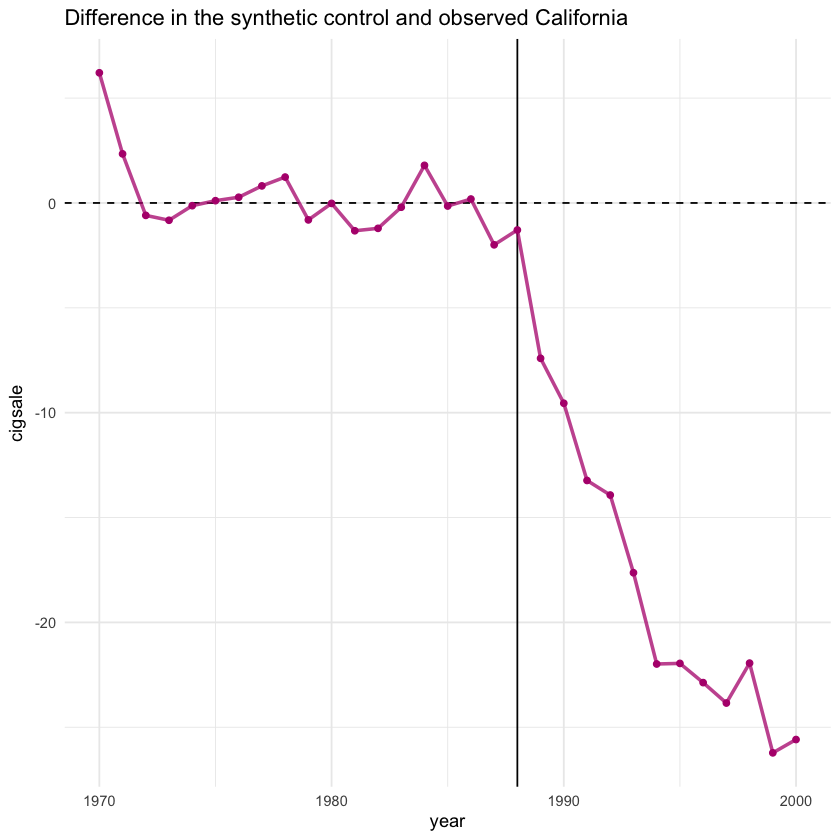

In [12]:
#真实加州和合成加州差值趋势图
smoking_out %>% plot_differences()

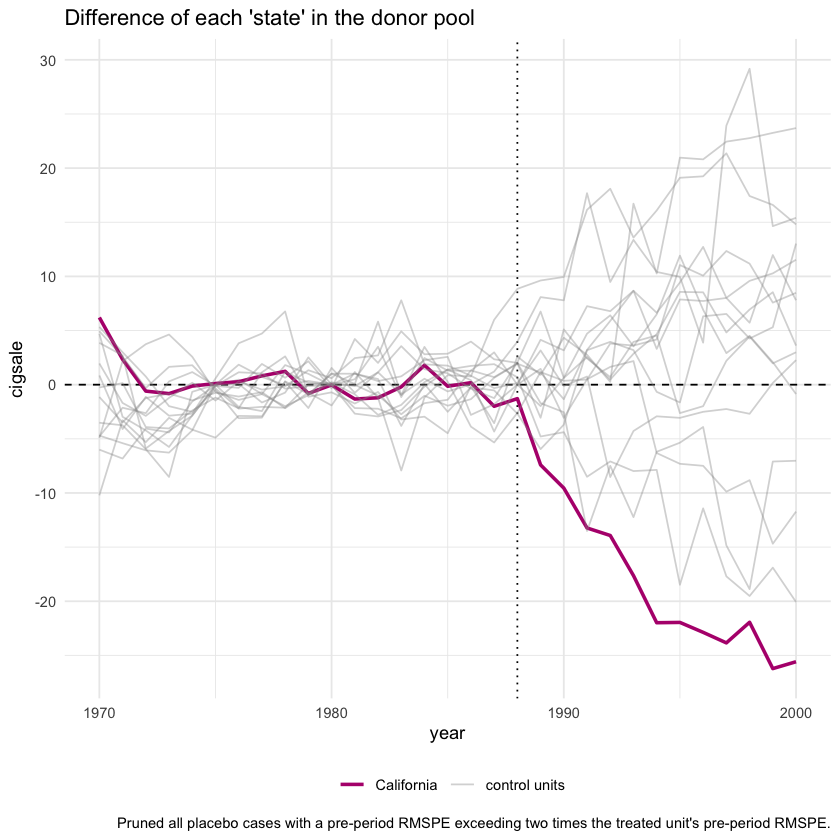

In [13]:
# 安慰剂检验（默认删除干预前拟合较差的安慰剂检验）
smoking_out %>% plot_placebos()

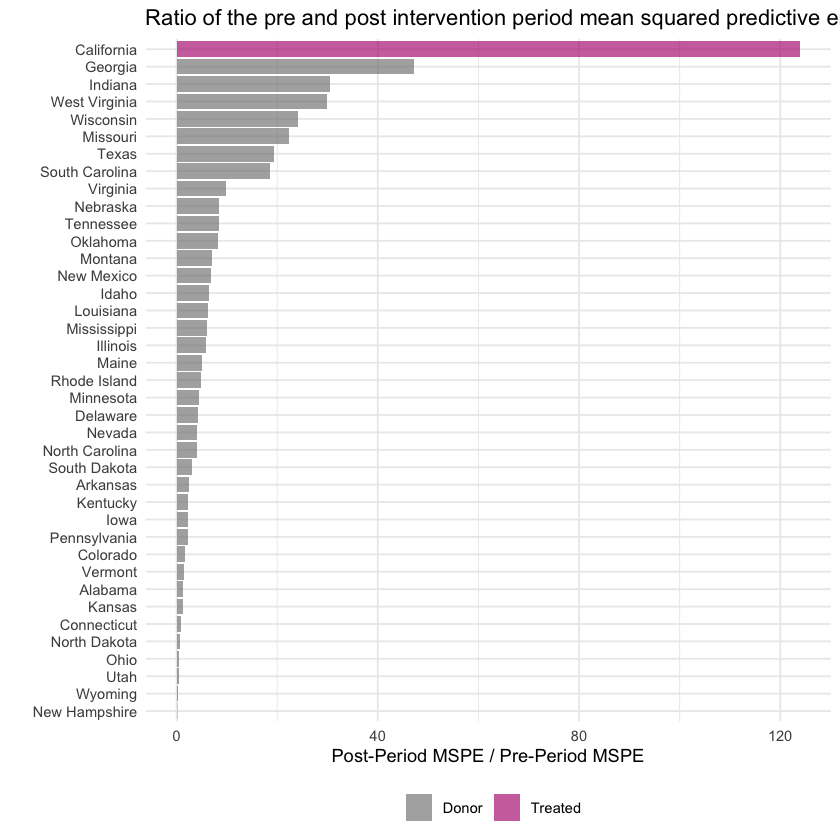

In [14]:
# 绘制干预后/前MSPE
smoking_out %>% plot_mspe_ratio()
# 干预后/前MSPE具体数值及P值
# smoking_out %>% grab_significance()

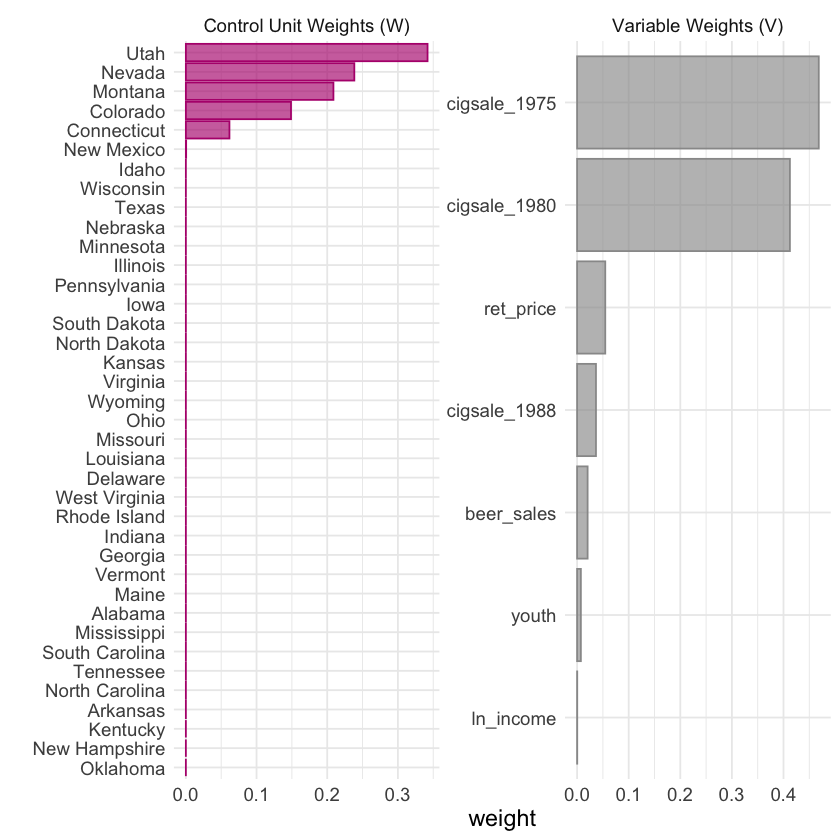

In [15]:
smoking_out %>% plot_weights()

In [16]:
placebo_results <- grab_placebo_mspe_ratio(smoking_out)
p_value <- mean(placebo_results$mspe_ratio >= treated_mspe_ratio)

ERROR: Error in grab_placebo_mspe_ratio(smoking_out): could not find function "grab_placebo_mspe_ratio"
